
-----

## Prerequisite: Data Lake Setup (S3 & Glue)

### 1\. Create the S3 Bucket

  * Navigate to the **S3 Console**.
  * Click **Create bucket**.
  * **Bucket name:** `olist-analytics-data-[your-account-id]` (must be globally unique).
  * Keep default settings (Block all public access should be **on**).

### 2\. Upload OLIST CSV Files

  * In the S3 console, enter your bucket and click **Upload**.
  * Drag and drop the CSV files.
  
### 3\. Create Athena Database via Glue Crawler

We will use a Crawler to automatically infer the schema from your CSVs.

  * Go to **AWS Glue Console** -\> **Crawlers** -\> **Create crawler**.
  * **Name:** `olist-crawler`.
  * **Data source:** Add your S3 bucket path (e.g., `s3://olist-analytics-data-.../`).
  * **IAM Role:** Create a new role (Glue will auto-generate one for you).
  * **Output Database:** Click **Add database** and name it `olist_db`.
  * **Classifier** create and assgn a CSV classifier with "has headings" enabled
  * **Schedule:** Set to **On demand**.
  * **Run Crawler:** Once created, select the crawler and click **Run**. This will populate the `olist_db` with tables corresponding to your CSVs.


### 4\. Assign permission for your notebook to access S3, Athena and Glue for querying the Olist database with SageMaker SQL

1. In IAM -> Roles find AmazonSageMaker-ExecutionRole-XXXXXXXXXXXXX
2. Add Permissions: * Click Add permissions -> Attach policies.
3. Search for the followoing policies: `AWSGlueConsoleFullAccess`, `AmazonAthenaFullAccess`, `AmazonS3FullAccess`
4. Grant the Permission in IAM

In [1]:
import sagemaker
print(sagemaker.get_execution_role())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
arn:aws:iam::254283132378:role/service-role/AmazonSageMaker-ExecutionRole-20251215T191125


## Part 1: Analytics Environment (SageMaker AI)

### 4\. Open a SageMaker Serverless Notebook

Use the **SageMaker AI** (formerly SageMaker Studio) interface.

1.  Navigate to **Amazon SageMaker** in the AWS Console.
2.  Click on **SageMaker AI** (or Studio) in the left sidebar.
3.  Under the **Applications** section, select **JupyterLab**.
4.  Create or Open a **Space**.
5.  Inside the JupyterLab interface, you are running in a managed, serverless environment. Simply open a new `.ipynb` file using the **Python 3 (Data Science)** kernel.

-----

Use **SQL Magic commands**. This is often preferred by Data Engineers because it allows you to write raw SQL in a cell without wrapping it in Python strings, providing better syntax highlighting and readability.

To do this, we use the `ipython-sql` extension and the `PyAthena` driver.

### 1\. Install and Load the Extension

Run this in your first notebook cell to set up the environment:

In [2]:
# Install the necessary libraries
!pip install ipython-sql pyathena --quiet

# Load the SQL magic extension
%load_ext sql

### 2\. Connect to Athena

Instead of a standard Python connection object, you will pass a connection string to the `%sql` magic command. Replace the placeholders with your specific S3 bucket (created in Step 1) and your region.

In [3]:
import urllib.parse

# Configuration
region = "us-east-1"
athena_db = "olist_db"
# S3 path for Athena to store query results (must end with a /)
s3_output = "s3://olist-analytics-data-results/output/"

# Encode the S3 path for the connection string
connection_string = f"awsathena+rest://@athena.{region}.amazonaws.com/{athena_db}?s3_staging_dir={urllib.parse.quote_plus(s3_output)}"

# Connect the magic command to Athena
%sql $connection_string

In [4]:
# Fix the PrettyTable version conflict
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [5]:
%%sql
SHOW TABLES IN olist_db;

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


tab_name
customers
geolocation
order_items
order_payments
order_reviews
orders
product_category_name_translation
products
sellers


In [6]:
# Capture the result into a variable called 'schema_result'
result = %sql DESCRIBE order_payments

# Print the raw rows to see the schema
for row in result:
    print(row[0])

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.
order_id            	string              	                    
payment_sequential  	bigint              	                    
payment_type        	string              	                    
payment_installments	bigint              	                    
payment_value       	double              	                    


In [7]:
%%sql
select * from products
limit 5

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
"""1e9e8ef04dbcff4541ed26657ea517e5""",perfumaria,40,287,1,225,16,10,14
"""3aa071139cb16b67ca9e5dea641aaa2f""",artes,44,276,1,1000,30,18,20
"""96bd76ec8810374ed1b65e291975717f""",esporte_lazer,46,250,1,154,18,9,15
cef67bcfe19066a932b7673e239eb23d,bebes,27,261,1,371,26,4,26
"""9dc1a7de274444849c219cff195d0b71""",utilidades_domesticas,37,402,4,625,20,17,13


In [8]:
%%sql
select * from order_items
limit 5

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
"""00010242fe8c5a6d1ba2dd792cb16214""",1,"""4244733e06e7ecb4970a6e2683c13e61""","""48436dade18ac8b2bce089ec2a041202""",2017-09-19 09:45:35,58.9,13.29
"""00018f77f2f0320c557190d7a144bdd3""",1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
"""000229ec398224ef6ca0657da4fc703e""",1,c777355d18b72b67abbeef9df44fd0fd,"""5b51032eddd242adc84c38acab88f23d""",2018-01-18 14:48:30,199.0,17.87
"""00024acbcdf0a6daa1e931b038114c75""",1,"""7634da152a4610f1595efa32f14722fc""","""9d7a1d34a5052409006425275ba1c2b4""",2018-08-15 10:10:18,12.99,12.79
"""00042b26cf59d7ce69dfabb4e55b4fd9""",1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9,18.14


In [9]:
%%sql
select * from geolocation
limit 5

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
None,-23.54562128115268,-46.63929204800168,sao paulo,SP
None,-23.546081127035535,-46.64482029837157,sao paulo,SP
None,-23.54612896641469,-46.64295148361138,sao paulo,SP
None,-23.5443921648681,-46.63949930627844,sao paulo,SP
None,-23.541577961711493,-46.64160722329613,sao paulo,SP


In [10]:
%%sql
select * from sellers
limit 5

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


seller_id,seller_zip_code_prefix,seller_city,seller_state
"""3442f8959a84dea7ee197c632cb2df15""",None,campinas,SP
d1b65fc7debc3361ea86b5f14c68d2e2,None,mogi guacu,SP
ce3ad9de960102d0677a81f5d0bb7b2d,None,rio de janeiro,RJ
c0f3eea2e14555b6faeea3dd58c1b1c3,None,sao paulo,SP
"""51a04a8a6bdcb23deccc82b0b80742cf""",None,braganca paulista,SP


#### Query
identify the Top 5 Product Categories by sales volume by joining transaction data with product metadata.

In [11]:
%%sql
/* Join items with products to get category names */
SELECT
    p.product_category_name,
    COUNT(oi.order_id) as items_sold
FROM order_items oi
JOIN products p 
    ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY items_sold DESC
LIMIT 5;

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


product_category_name,items_sold
cama_mesa_banho,11115
beleza_saude,9670
esporte_lazer,8641
moveis_decoracao,8334
informatica_acessorios,7827


##### 1. Identifying "Heavy Hitters" by Category
This query helps the logistics team understand which product categories are the bulkiest and most expensive to ship. By joining order_items and products, we can calculate the average density or weight per category.

The Insight: High freight costs relative to product price can kill conversion rates. This identifies categories that might need better packaging or local warehousing.

In [12]:
%%sql
SELECT 
    p.product_category_name,
    COUNT(oi.order_id) AS total_orders,
    ROUND(AVG(oi.price), 2) AS avg_price,
    ROUND(AVG(oi.freight_value), 2) AS avg_freight,
    ROUND(AVG(p.product_weight_g), 0) AS avg_weight_g
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name  -- In Athena, it's safer to use the full column name
HAVING COUNT(oi.order_id) > 100   -- Change total_orders to the actual COUNT()
ORDER BY avg_freight DESC;

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


product_category_name,total_orders,avg_price,avg_freight,avg_weight_g
pcs,203,1098.34,48.45,7217.0
eletrodomesticos_2,238,476.12,44.54,8958.0
moveis_cozinha_area_de_servico_jantar_e_jardim,281,164.87,42.7,8853.0
moveis_quarto,109,183.75,42.5,9989.0
moveis_escritorio,1691,162.01,40.55,11390.0
moveis_sala,503,137.01,35.72,8093.0
sinalizacao_e_seguranca,199,108.09,32.7,3887.0
industria_comercio_e_negocios,268,148.02,29.42,6664.0
malas_acessorios,1092,128.6,27.88,5775.0
agro_industria_e_comercio,212,342.12,27.56,3625.0


##### 2. Seller Geographic Performance & Density
By joining sellers with order_items, we can see which Brazilian states are the primary hubs for commerce. We then join the geolocation table to get coordinates, which could be used for a heat map.

The Insight: If 80% of your electronics sellers are in São Paulo (SP) but 50% of your customers are in the North, you have a massive shipping lead-time problem.

In [31]:
%%sql
SELECT 
    s.seller_state,
    COUNT(DISTINCT s.seller_id) AS seller_count,
    ROUND(SUM(oi.price), 2) AS total_revenue,
    -- Get the average center-point of sellers in that state
    AVG(g.geolocation_lat) AS avg_lat,
    AVG(g.geolocation_lng) AS avg_lng
FROM sellers s
JOIN order_items oi ON s.seller_id = oi.seller_id
LEFT JOIN geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY 1
ORDER BY total_revenue DESC;

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


seller_state,seller_count,total_revenue,avg_lat,avg_lng
SP,1849,8753396.21,None,None
PR,349,1261887.21,None,None
MG,244,1011564.74,None,None
RJ,170,843194.42,None,None
SC,190,632426.07,None,None
RS,128,378492.9,None,None
BA,19,285561.56,None,None
DF,30,97749.48,None,None
PE,9,91493.85,None,None
GO,40,66399.21,None,None


##### 3. Product Presentation vs. Sales PerformanceDoes

"more information" lead to more sales? This query analyzes whether the length of a product's description or the number of photos correlates with higher sales volume.The Insight: This helps the marketing team set "Catalog Standards." If products with $>5$ photos sell 20% more, you can make that a requirement for sellers.

In [14]:
%%sql
SELECT 
    CASE 
        WHEN product_photos_qty <= 2 THEN 'Low (0-2)'
        WHEN product_photos_qty <= 5 THEN 'Medium (3-5)'
        ELSE 'High (5+)' 
    END AS photo_tier,
    COUNT(oi.order_id) AS sales_volume,
    ROUND(AVG(p.product_description_lenght), 0) AS avg_desc_length,
    ROUND(SUM(oi.price), 0) AS total_revenue
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY 1
ORDER BY sales_volume DESC;

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


photo_tier,sales_volume,avg_desc_length,total_revenue
Low (0-2),77991,744.0,8820878.0
Medium (3-5),26197,851.0,3640206.0
High (5+),8462,1041.0,1130560.0


##### 4. Revenue Concentration by Seller City
This query identifies which cities are the "economic engines" of the marketplace by joining order_items and sellers.

The Insight: It helps identify regional clusters. If a specific city has high revenue but few sellers, it might be a specialized manufacturing hub (e.g., a furniture district).

In [15]:
%%sql

SELECT 
    s.seller_city,
    s.seller_state,
    COUNT(DISTINCT s.seller_id) AS seller_count,
    ROUND(SUM(oi.price), 2) AS total_revenue,
    ROUND(SUM(oi.price) / COUNT(DISTINCT s.seller_id), 2) AS revenue_per_seller
FROM order_items oi
JOIN sellers s ON oi.seller_id = s.seller_id
GROUP BY s.seller_city, s.seller_state
HAVING COUNT(DISTINCT s.seller_id) > 5
ORDER BY total_revenue DESC
LIMIT 10;

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


seller_city,seller_state,seller_count,total_revenue,revenue_per_seller
sao paulo,SP,694,2702878.14,3894.64
ibitinga,SP,49,624592.94,12746.79
curitiba,PR,124,467821.52,3772.75
rio de janeiro,RJ,93,358126.92,3850.83
guarulhos,SP,50,329494.38,6589.89
ribeirao preto,SP,52,275976.44,5307.24
itaquaquecetuba,SP,9,230568.12,25618.68
santo andre,SP,45,228561.6,5079.15
piracicaba,SP,12,212677.82,17723.15
maringa,PR,40,207257.51,5181.44


##### 5. Physical Profile of Best-Selling Categories

By joining order_items and products, we can see if the physical size (volume) of a product relates to its sales frequency. We calculate volume as $Length \times Height \times Width$.The Insight: High-volume, low-price items are "Logistics Traps"—they take up massive warehouse space but offer low margins. This query flags those categories.

In [16]:
%%sql

SELECT 
    p.product_category_name,
    COUNT(oi.order_id) AS total_units_sold,
    ROUND(AVG(p.product_length_cm * p.product_height_cm * p.product_width_cm), 0) AS avg_volume_cm3,
    ROUND(AVG(oi.price), 2) AS avg_price
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
WHERE p.product_category_name IS NOT NULL
GROUP BY p.product_category_name
HAVING COUNT(oi.order_id) > 100
ORDER BY avg_volume_cm3 DESC;

 * awsathena+rest://@athena.us-east-1.amazonaws.com/olist_db?s3_staging_dir=s3%3A%2F%2Folist-analytics-data-results%2Foutput%2F
Done.


product_category_name,total_units_sold,avg_volume_cm3,avg_price
moveis_escritorio,1691,74018.0,162.01
moveis_cozinha_area_de_servico_jantar_e_jardim,281,51949.0,164.87
eletrodomesticos_2,238,47955.0,476.12
moveis_quarto,109,47933.0,183.75
moveis_sala,503,42625.0,137.01
industria_comercio_e_negocios,268,41983.0,148.02
pcs,203,41927.0,1098.34
malas_acessorios,1092,39505.0,128.6
sinalizacao_e_seguranca,199,31044.0,108.09
bebes,3065,27146.0,134.34


-----


### 4\. Convert SQL Cell Results to Pandas

One of the best features of SQL magic is that you can "capture" the output of a SQL cell directly into a Pandas DataFrame using the assignment syntax.

In [17]:
# Use the << operator to assign the result of the SQL query to a variable named 'df_performance'
%%sql df_performance <<
SELECT
    order_status,
    COUNT(*) as count
FROM olist_orders_dataset
GROUP BY order_status

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│     order_status,                                                                                │
│    ▲                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndentationError: unexpected indent

In [18]:
# Now 'df_performance' is a standard Pandas DataFrame
print(type(df_performance))
df_performance.head()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Now 'df_performance' is a standard Pandas DataFrame                                        │
│ ❱ 2 print(type(df_performance))                                                                  │
│   3 df_performance.head()                                                                        │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df_performance' is not defined

-----

**Next Step:** Would you like to see how to create a **SageMaker Feature Store** from these SQL results to prepare the data for an ML model?

In [19]:
import sagemaker
import pandas as pd
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

# 1. Get your default SageMaker S3 bucket automatically
sess = sagemaker.Session()
default_bucket = sess.default_bucket()
s3_path = f"s3://{default_bucket}/athena-results/"

# 2. Setup connection using the verified bucket
conn = connect(
    s3_staging_dir=s3_path,
    region_name='us-east-1', # Ensure this matches your notebook region
    cursor_class=PandasCursor
)

# 3. Run your analysis
query = """
SELECT 
    p.product_category_name,
    COUNT(oi.order_id) AS total_units_sold,
    ROUND(AVG(oi.price), 2) AS avg_price
FROM olist_db.order_items oi
JOIN olist_db.products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
HAVING COUNT(oi.order_id) > 100
ORDER BY total_units_sold DESC
"""

df = conn.cursor().execute(query).as_pandas()

# View the results
print(df.head())

    product_category_name  total_units_sold  avg_price
0         cama_mesa_banho             11115      93.30
1            beleza_saude              9670     130.16
2           esporte_lazer              8641     114.34
3        moveis_decoracao              8334      87.56
4  informatica_acessorios              7827     116.51


In [20]:
# Query 1: Top 5 Cities by Order Count (Group By)
query_1 = f"""
SELECT 
    p.product_category_name,
    COUNT(oi.order_id) AS total_units_sold,
    ROUND(AVG(p.product_length_cm * p.product_height_cm * p.product_width_cm), 0) AS avg_volume_cm3,
    ROUND(AVG(oi.price), 2) AS avg_price
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
WHERE p.product_category_name IS NOT NULL
GROUP BY p.product_category_name
HAVING COUNT(oi.order_id) > 100
ORDER BY avg_volume_cm3 DESC;
"""

In [21]:
query_1 = """
SELECT 
    p.product_category_name,
    COUNT(oi.order_id) AS total_units_sold,
    ROUND(AVG(p.product_length_cm * p.product_height_cm * p.product_width_cm), 0) AS avg_volume_cm3,
    ROUND(AVG(oi.price), 2) AS avg_price
FROM olist_db.order_items oi
JOIN olist_db.products p ON oi.product_id = p.product_id
WHERE p.product_category_name IS NOT NULL
GROUP BY p.product_category_name
HAVING COUNT(oi.order_id) > 100
ORDER BY avg_volume_cm3 DESC
"""

# Execute using the connection we set up previously
df_volume = conn.cursor().execute(query_1).as_pandas()
print(df_volume.head())

                            product_category_name  total_units_sold  \
0                               moveis_escritorio              1691   
1  moveis_cozinha_area_de_servico_jantar_e_jardim               281   
2                              eletrodomesticos_2               238   
3                                   moveis_quarto               109   
4                                     moveis_sala               503   

   avg_volume_cm3  avg_price  
0         74018.0     162.01  
1         51949.0     164.87  
2         47955.0     476.12  
3         47933.0     183.75  
4         42625.0     137.01  


### 7\. Import Results into Pandas DataFrame

The most efficient way to handle this in SageMaker is to use the `pd.read_sql` function.

In [22]:

# 1. Automatically get a bucket you definitely have access to
sess = sagemaker.Session()
my_s3_staging_dir = f"s3://{sess.default_bucket()}/athena-results/"

# 2. Connect using the PandasCursor
conn = connect(
    s3_staging_dir=my_s3_staging_dir,
    region_name='us-east-1',
    cursor_class=PandasCursor
)

# 3. Your query (cleaned of any hidden characters)
query_1 = """
SELECT 
    p.product_category_name,
    COUNT(oi.order_id) AS total_units_sold,
    ROUND(AVG(p.product_length_cm * p.product_height_cm * p.product_width_cm), 0) AS avg_volume_cm3,
    ROUND(AVG(oi.price), 2) AS avg_price
FROM olist_db.order_items oi
JOIN olist_db.products p ON oi.product_id = p.product_id
WHERE p.product_category_name IS NOT NULL
GROUP BY p.product_category_name
HAVING COUNT(oi.order_id) > 100
ORDER BY avg_volume_cm3 DESC
"""

# 4. Execute and get the DataFrame directly
df = conn.cursor().execute(query_1).as_pandas()

# Display results
df.head()

,product_category_name,total_units_sold,avg_volume_cm3,avg_price
0,moveis_escritorio,1691,74018.0,162.01
1,moveis_cozinha_area_de_servico_jantar_e_jardim,281,51949.0,164.87
2,eletrodomesticos_2,238,47955.0,476.12
3,moveis_quarto,109,47933.0,183.75
4,moveis_sala,503,42625.0,137.01


##### Scenario 1: Sales Volume by Category (Bar Chart)
The Goal: Identify which product categories drive the most transactions. Plot Type: Horizontal Bar Chart (best for long category names).

/tmp/ipykernel_324/3246598717.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_orders', y='product_category_name', data=df_bar, palette='viridis')


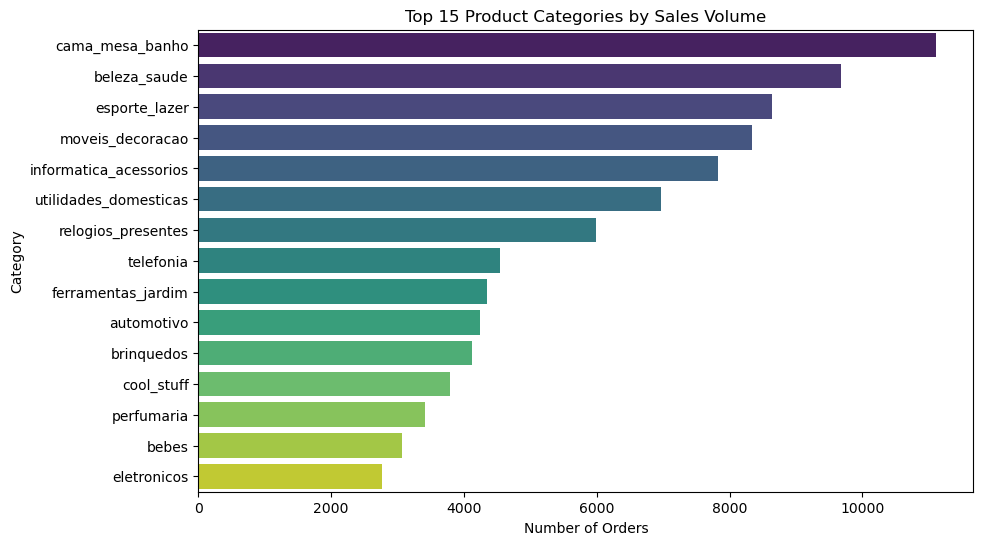

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SQL Query
query_bar = """
SELECT 
    p.product_category_name, 
    COUNT(oi.order_id) AS total_orders
FROM olist_db.order_items oi
JOIN olist_db.products p ON oi.product_id = p.product_id
WHERE p.product_category_name IS NOT NULL
GROUP BY p.product_category_name
ORDER BY total_orders DESC
LIMIT 15
"""

# 2. Fetch Data
df_bar = conn.cursor().execute(query_bar).as_pandas()

# 3. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='total_orders', y='product_category_name', data=df_bar, palette='viridis')
plt.title('Top 15 Product Categories by Sales Volume')
plt.xlabel('Number of Orders')
plt.ylabel('Category')
plt.show()

##### Scenario 2: Weight vs. Freight Cost (Scatter Plot)
The Goal: See if heavier products consistently cost more to ship, or if other factors (like seller location) create outliers. Plot Type: Scatter Plot with a regression line.

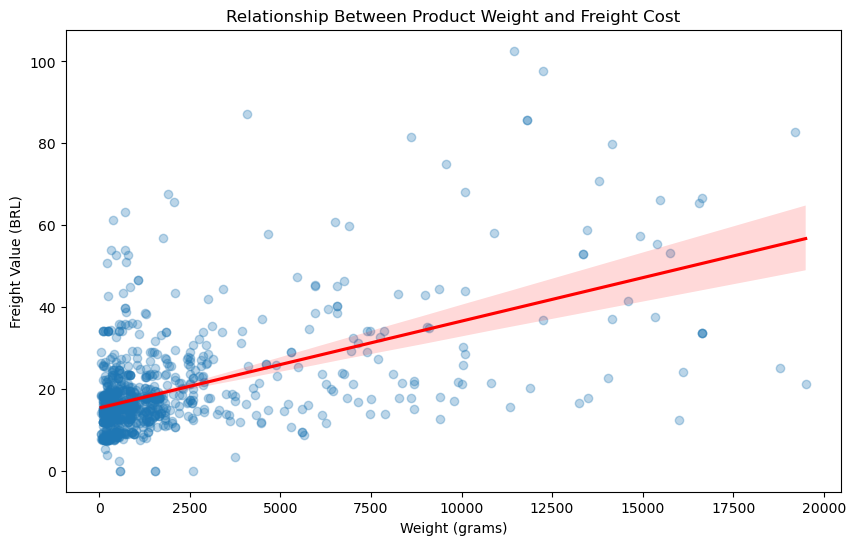

In [24]:
# 1. SQL Query (Sampling 1000 rows for performance)
query_scatter = """
SELECT 
    p.product_weight_g, 
    oi.freight_value
FROM olist_db.order_items oi
JOIN olist_db.products p ON oi.product_id = p.product_id
WHERE p.product_weight_g IS NOT NULL 
  AND p.product_weight_g < 20000 -- Filter out extreme outliers for better visual
LIMIT 1000
"""

# 2. Fetch Data
df_scatter = conn.cursor().execute(query_scatter).as_pandas()

# 3. Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='product_weight_g', y='freight_value', data=df_scatter, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relationship Between Product Weight and Freight Cost')
plt.xlabel('Weight (grams)')
plt.ylabel('Freight Value (BRL)')
plt.show()

### Scenario 3: Seller Concentration by State (Pie Chart)
The Goal: Visualize the geographic distribution of the marketplace's supply side. Plot Type: Pie Chart (or Donut Chart).

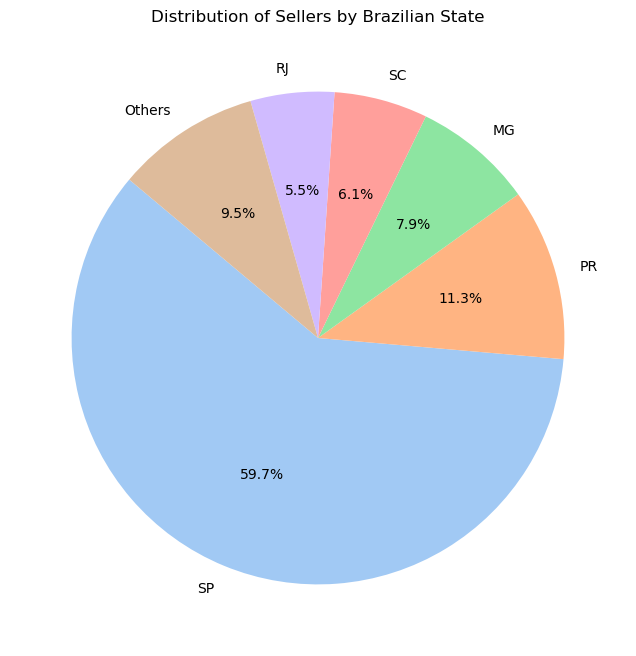

In [25]:
# 1. SQL Query
query_pie = """
SELECT 
    seller_state, 
    COUNT(seller_id) AS seller_count
FROM olist_db.sellers
GROUP BY seller_state
ORDER BY seller_count DESC
"""

# 2. Fetch Data
df_pie = conn.cursor().execute(query_pie).as_pandas()

# 3. Plot
# We'll group smaller states into "Other" for a cleaner chart
top_states = df_pie.head(5)
other_states_count = df_pie['seller_count'][5:].sum()
final_pie = pd.concat([top_states, pd.DataFrame({'seller_state':['Others'], 'seller_count':[other_states_count]})])

plt.figure(figsize=(8, 8))
plt.pie(final_pie['seller_count'], labels=final_pie['seller_state'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Sellers by Brazilian State')
plt.show()

In [ ]:
# Function to execute and return DataFrame
def get_athena_data(query):
    return pd.read_sql(query, conn)

# Load Top Cities into DF
df_cities = get_athena_data(query_1)

# Load Revenue Analysis into DF
df_revenue = get_athena_data(query_2)

# Display results
print("Top Cities Analysis:")
print(df_cities.head())

print("\nRevenue by Payment Type:")
print(df_revenue.head())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

-----

### 2\. Visualization 1: Monthly Revenue Trend (Growth Analysis)

We will pull the monthly revenue to see how the business is scaling.

In [ ]:
# Query data into a DataFrame
df_revenue_trend = get_athena_data(f"""
    SELECT
        date_format(CAST(o.order_purchase_timestamp AS TIMESTAMP), '%Y-%m-01') AS month,
        SUM(p.payment_value) AS total_revenue
    FROM "{DATABASE}"."olist_orders_dataset" o
    JOIN "{DATABASE}"."olist_order_payments_dataset" p ON o.order_id = p.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY 1
    ORDER BY 1
""")

# Convert month string to datetime for better plotting
df_revenue_trend['month'] = pd.to_datetime(df_revenue_trend['month'])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_revenue_trend, x='month', y='total_revenue', marker='o', color='#2ecc71')
plt.title('OLIST Monthly Revenue Trend (BRL)', fontsize=15)
plt.xlabel('Order Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

-----

### 3\. Visualization 2: Payment Method Distribution

This helps identify the most popular financial rails in the Brazilian market.

In [ ]:
# Query data
df_payments = get_athena_data(f"""
    SELECT payment_type, COUNT(*) as count
    FROM "{DATABASE}"."olist_order_payments_dataset"
    GROUP BY payment_type
    ORDER BY count DESC
""")

# Plotting a Pie Chart (better for distribution)
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:5]
plt.pie(df_payments['count'], labels=df_payments['payment_type'], autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Customer Payment Method Distribution', fontsize=15)
plt.show()

-----

### 4\. Visualization 3: Top 10 Product Categories by Revenue

This join-heavy query identifies which categories drive the most value.

In [ ]:
# Query data
df_top_categories = get_athena_data(f"""
    SELECT
        p.product_category_name,
        SUM(i.price) as total_sales
    FROM "{DATABASE}"."olist_order_items_dataset" i
    JOIN "{DATABASE}"."olist_products_dataset" p ON i.product_id = p.product_id
    WHERE p.product_category_name IS NOT NULL
    GROUP BY p.product_category_name
    ORDER BY total_sales DESC
    LIMIT 10
""")

# Plotting a Horizontal Bar Chart
sns.barplot(data=df_top_categories, x='total_sales', y='product_category_name', palette='viridis')
plt.title('Top 10 Product Categories by Revenue', fontsize=15)
plt.xlabel('Total Sales (BRL)')
plt.ylabel('Category Name')
plt.tight_layout()
plt.show()

-----

### 5\. Architectural Tip: Handling "Big Data" in SageMaker

If your OLIST dataset grows to millions of rows:

1.  **Sampling:** Use `TABLESAMPLE BERNOULLI (10)` in your SQL query to pull only a 10% representative sample into Pandas to save memory.
2.  **Parquet Conversion:** In Step 3 (Crawler), if you convert your CSVs to **Parquet** format in S3, your Athena queries will run up to **10x faster** and cost **90% less** because Athena only reads the columns needed for the visualization.

**Next Step:** Would you like to build a **Linear Regression model** in this notebook to predict future delivery times based on the geographic data we just visualized?